<h1><center>Chatbot for Mental Health and Human Stress Prediction</center></h1>
<center>by Chao Xu</center>

<h2>I: Introduction</h2>

This project is aimed to build a chatbot who can make mental health conversation and also detect psychological  stress based on the conversation.

Datasets:
- **Mental Health Conversational Data** (https://www.kaggle.com/datasets/elvis23/mental-health-conversational-data/data)
- **Human Stress Prediction** (https://www.kaggle.com/datasets/cbf36c44e2c14007b6aedffc307e1f7f7c6d0b9e1e96c8895f36658842a6ece4)

With these datasets, I will use different NLP techniques to build two different models and finally use the models to build a chatbot. The main steps are as follows:
- Conversational Module:
    - Cleaning the *Mental Health Conversational data*.
    - Analyzing the preset questions and plotting word frequencies using **Tokenization**, **Stopwords**, **RegEx**, and **Word frequency distributions**.
    - Build a pipeline to create a model for conversation using **Stemming**, **Count Vectorization**, **TF-IDF**, **Decision Tree**, **SVM** and **Naive Bayes**.
    - Test the models with random questions to keep the best model.
- Stress Prediction Module:
    - Cleaning and analyzing the *Human Stress Prediction data*.
    - Create a **WordCloud** of all the text in the data.
    - Visualize **Named Entities** of a sample text Using spaCy.
    - Build pipelines to create two models for stress prediction using **Count Vectorization**, **TF-IDF**, **Naive Bayes**, and **Logistic Regression**.
    - Compare these models with accuracy, confusion matrix, and classification report.
- Chatbot Module:
    - Using the prediction of the two models to generate conversations for the chatbot. 
    - Test the chatbot with two different situations (stress and no stress)

<h2>II: Import Libraries

In [54]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import spacy
import re

import warnings
warnings.filterwarnings('ignore')

<h2>III: Conversational Module

<h3>Load the Mental Health Conversational Data

In [2]:
df_faq = pd.read_json('Data/intents.json')
df_faq.head()

,intents
0,"{'tag': 'greeting', 'patterns': ['Hi', 'Hey', ..."
1,"{'tag': 'morning', 'patterns': ['Good morning'..."
2,"{'tag': 'afternoon', 'patterns': ['Good aftern..."
3,"{'tag': 'evening', 'patterns': ['Good evening'..."
4,"{'tag': 'night', 'patterns': ['Good night'], '..."


This is a typical JSON file. In order to read it better, I need to use *.json_normalize()* to convert the 'intents' column into a flat table.

In [3]:
df_faq = pd.json_normalize(df_faq['intents'])

In [4]:
#Show the head of df_faq with the full content
from IPython.display import HTML
HTML(df_faq.head(6).to_html())

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, Hey there, Howdy, Hola, Bonjour, Konnichiwa, Guten tag, Ola]","[Hello there. Tell me how are you feeling today?, Hi there. What brings you here today?, Hi there. How are you feeling today?, Great to see you. How do you feel currently?, Hello there. Glad to see you're back. What's going on in your world right now?]"
1,morning,[Good morning],[Good morning. I hope you had a good night's sleep. How are you feeling today? ]
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night. Sweet dreams.]"
5,goodbye,"[Bye, See you later, Goodbye, Au revoir, Sayonara, ok bye, Bye then, Fare thee well]","[See you later., Have a nice day., Bye! Come back again., I'll see you soon.]"


In [5]:
HTML(df_faq.tail(2).to_html())

,tag,patterns,responses
78,fact-31,[What's the difference between anxiety and stress?],"[Stress and anxiety are often used interchangeably, and there is overlap between stress and anxiety. Stress is related to the same fight, flight, or freeze response as anxiety, and the physical sensations of anxiety and stress may be very similar. The cause of stress and anxiety are usually different, however. Stress focuses on mainly external pressures on us that we're finding hard to cope with. When we are stressed, we usually know what we're stressed about, and the symptoms of stress typically disappear after the stressful situation is over. Anxiety, on the other hand, isn't always as easy to figure out. Anxiety focuses on worries or fears about things that could threaten us, as well as anxiety about the anxiety itself. Stress and anxiety are both part of being human, but both can be problems if they last for a long time or have an impact on our well-being or daily life.]"
79,fact-32,"[What's the difference between sadness and depression?, difference between sadness and depression]","[Sadness is a normal reaction to a loss, disappointment, problems, or other difficult situations. Feeling sad from time to time is just another part of being human. In these cases, feelings of sadness go away quickly and you can go about your daily life. Other ways to talk about sadness might be feeling low, feeling down, or feeling blue.A person may say they are feeling depressed, but if it goes away on its own and doesn't impact life in a big way, it probably isn't the illness of depression. Depression is a mental illness that affects your mood, the way you understand yourself, and the way you understand and relate to things around you. It can also go by different names, such as clinical depression, major depressive disorder, or major depression. Depression can come up for no reason, and it lasts for a long time. It's much more than sadness or low mood. People who experience depression may feel worthless or hopeless. They may feel unreasonable guilty. Some people may experience depression as anger or irritability. It may be hard to concentrate or make decisions. Most people lose interest in things that they used to enjoy and may isolate themselves from others. There are also physical signs of depression, such as problems with sleep, appetite and energy and unexplainable aches or pains. Some may experience difficult thoughts about death or ending their life (suicide). Depression lasts longer than two weeks, doesn't usually go away on its own, and impacts your life. It's a real illness, and it is very treatable. It's important to seek help if you're concerned about depression.]"


There are three columns in this dataset.
- Column 'tag' represents the label of the questions.
- Column 'patterns' list some questions corresponding to their labels. Each pattern is a list including multiple questions related to the tag.
- Column 'responses' list the corresponding answers. Each response is also a list including some responses related to the questions.
- The head of the data shows some general conversation intents such as greeting and goodbye.
- The tail of the data shows some general questions related to mental health, which will be the main purpose of this chatbot.

<h3>Cleaning and Analyzing Data

Since some of the questions are nested in a list, it is better to extract every question and put it in a single row.

In [6]:
#Extract the values from the list stored in column 'patterns' and split up the data over multiple rows
new_df_faq = df_faq.explode(['patterns']).reset_index(drop=True)

new_df_faq.head()

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...


<h4>Check the Tags

In [7]:
#Print the unique values for the 'tag' column
print('There are', len(new_df_faq['tag'].unique()), 'unique tags in this dataset.')
print('The tags are:')
print(new_df_faq['tag'].unique())

There are 80 unique tags in this dataset.
The tags are:
['greeting' 'morning' 'afternoon' 'evening' 'night' 'goodbye' 'thanks'
 'no-response' 'neutral-response' 'about' 'skill' 'creation' 'name' 'help'
 'sad' 'stressed' 'worthless' 'depressed' 'happy' 'casual' 'anxious'
 'not-talking' 'sleep' 'scared' 'death' 'understand' 'done' 'suicide'
 'hate-you' 'hate-me' 'default' 'jokes' 'repeat' 'wrong' 'stupid'
 'location' 'something-else' 'friends' 'ask' 'problem' 'no-approach'
 'learn-more' 'user-agree' 'meditation' 'user-meditation' 'pandora-useful'
 'user-advice' 'learn-mental-health' 'mental-health-fact' 'fact-1'
 'fact-2' 'fact-3' 'fact-5' 'fact-6' 'fact-7' 'fact-8' 'fact-9' 'fact-10'
 'fact-11' 'fact-12' 'fact-13' 'fact-14' 'fact-15' 'fact-16' 'fact-17'
 'fact-18' 'fact-19' 'fact-20' 'fact-21' 'fact-22' 'fact-23' 'fact-24'
 'fact-25' 'fact-26' 'fact-27' 'fact-28' 'fact-29' 'fact-30' 'fact-31'
 'fact-32']


There are 32 questions concerning mental health facts in detail. Some of the tags are keywords of mental health such as 'anxious' and 'suicide', others are about general conversations.

<h4>Tokenize the text in patterns column

In [8]:
word_list = []
tknzr = TweetTokenizer()
for question in new_df_faq['patterns']:
        words = tknzr.tokenize(question)
        word_list.extend(words)
word_set = set(word_list)
print('There are', len(word_list), 'words in the patterns column.')
print('There are', len(word_set), 'unique words in the patterns column.\n')
print(sorted(word_set))

There are 1146 words in the patterns column.
There are 337 unique words in the patterns column.

[',', '.', '?', 'All', 'Am', 'Are', 'Au', 'Bonjour', 'Bye', 'Can', 'Could', 'Define', 'Depression', 'Do', 'Fare', 'Fine', 'Good', 'Goodbye', 'Guten', 'Health', 'Hello', 'Hey', 'Hi', 'Hola', 'How', 'Howdy', 'I', "I'm", "I've", 'If', 'Is', 'Just', 'K', 'Konnichiwa', "Let's", 'Mental', 'My', 'No', 'Nobody', 'Nothing', 'Oh', 'Ola', 'Probably', 'Sayonara', 'See', 'Someone', 'Support', 'Tell', 'Than', 'Thank', 'Thanks', 'That', "That's", 'What', "What's", 'Whatever', 'Where', 'Who', 'Why', 'Wrong', 'Yeah', 'You', "You're", 'a', 'about', 'absolutely', 'advice', 'affect', 'afternoon', 'again', 'all', 'alot', 'already', 'am', 'and', 'another', 'answer', 'anxiety', 'anxious', 'any', 'anymore', 'anyone', 'anything', 'appears', 'approaching', 'are', 'ask', 'available', 'away', 'awful', 'be', 'because', 'become', 'before', 'better', 'between', 'boyfriend', 'break', 'bring', 'brother', 'burned', 'by', 'b

When I tokenize the test using *word_tokenize*, I noticed that some of the abbreviations are split into two parts such as "can't", "i'm". It is better to keep these abbreviations and clean it in a different way to keep the meaning of the words for training. 
- I used **TweetTokenizer** instead. The abbreviations are kept successfully. 
- However, in order to keep the original meaning, I also need to get rid of the single quote in the abbreviations when preparing for the training.
- There are some punctuations such as ",", ".", "?" are left. I will delete these later for plotting word frequencies.
- I will also remove the stopwords for plotting word frequencies.


<h4>Remove stopwords

In [9]:
#Put stopwords in a list
stop_words = stopwords.words('english')

#Remove stopwords from the word_list
clean_word_list = []
for w in word_list:
    if w.lower() not in stop_words:
        clean_word_list.append(w.lower())
print('There are', len(set(clean_word_list)), 'unique words in the patterns column without stopwords.\n')
print(sorted(set(clean_word_list)))

There are 238 unique words in the patterns column without stopwords.

[',', '.', '?', 'absolutely', 'advice', 'affect', 'afternoon', 'alot', 'already', 'another', 'answer', 'anxiety', 'anxious', 'anymore', 'anyone', 'anything', 'appears', 'approaching', 'ask', 'au', 'available', 'away', 'awful', 'become', 'better', 'bonjour', 'boyfriend', 'break', 'bring', 'brother', 'burned', 'bye', 'call', "can't", 'causes', 'cheerful', 'child', 'commit', 'connections', 'continue', 'control', 'could', 'crazy', 'created', 'cure', 'cures', 'dad', 'days', 'define', 'depressed', 'depression', 'deserve', 'die', 'died', 'difference', 'different', 'disorder', 'dumb', 'else', 'empty', 'enough', 'evening', 'exams', 'fact', 'family', 'fare', 'feel', 'feeling', 'financial', 'find', 'fine', 'focus', 'friend', 'friends', 'get', 'girlfriend', 'give', 'go', 'going', 'good', 'goodbye', 'great', 'group', 'guess', 'guten', 'hand', 'happy', 'hate', 'health', 'hello', 'help', 'helpful', 'hey', 'hi', 'hmmm', 'hola', 'how

<h4>Remove punctuations using RegEx

In [10]:
#Remove punctuations using RegEx
new_list = []
for word in clean_word_list:
    if not re.search(r'[\?\.,]', word):
        new_list.append(word)

print('There are', len(set(new_list)), 'unique words in the patterns column without stopwords and punctuations.\n')
print(sorted(set(new_list)))                          

There are 235 unique words in the patterns column without stopwords and punctuations.

['absolutely', 'advice', 'affect', 'afternoon', 'alot', 'already', 'another', 'answer', 'anxiety', 'anxious', 'anymore', 'anyone', 'anything', 'appears', 'approaching', 'ask', 'au', 'available', 'away', 'awful', 'become', 'better', 'bonjour', 'boyfriend', 'break', 'bring', 'brother', 'burned', 'bye', 'call', "can't", 'causes', 'cheerful', 'child', 'commit', 'connections', 'continue', 'control', 'could', 'crazy', 'created', 'cure', 'cures', 'dad', 'days', 'define', 'depressed', 'depression', 'deserve', 'die', 'died', 'difference', 'different', 'disorder', 'dumb', 'else', 'empty', 'enough', 'evening', 'exams', 'fact', 'family', 'fare', 'feel', 'feeling', 'financial', 'find', 'fine', 'focus', 'friend', 'friends', 'get', 'girlfriend', 'give', 'go', 'going', 'good', 'goodbye', 'great', 'group', 'guess', 'guten', 'hand', 'happy', 'hate', 'health', 'hello', 'help', 'helpful', 'hey', 'hi', 'hmmm', 'hola', 'h

Now all the stopwords and punctuations are removed. It's time to plot the word frequencies.

<h4>Get the 20 most common words

In [11]:
fdist = FreqDist(new_list)
fdist.most_common(20)

[('mental', 25),
 ('health', 19),
 ('feel', 16),
 ("i'm", 9),
 ('want', 9),
 ('know', 8),
 ("can't", 7),
 ('depression', 7),
 ('help', 6),
 ('tell', 6),
 ('need', 6),
 ('like', 6),
 ('learn', 6),
 ('good', 5),
 ('talk', 5),
 ('would', 5),
 ('problems', 5),
 ('illness', 5),
 ('ok', 4),
 ('much', 4)]

<h4>Plot the word frequencies

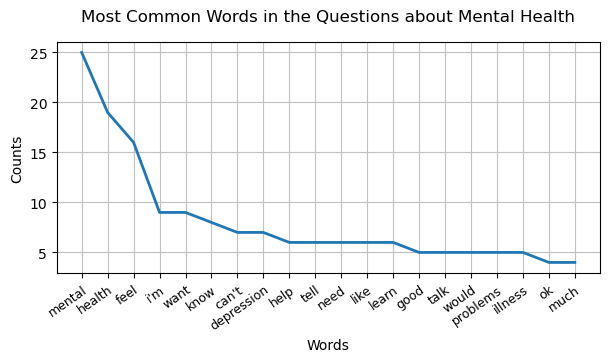

In [12]:
#Plot the 20 most common words on grpah:
fig, ax = plt.subplots(figsize=(7,3))
plt.title('Most Common Words in the Questions about Mental Health', pad=15)
ax = fdist.plot(20, show=False)

plt.setp(ax.get_xticklabels(), rotation=35, ha='right', rotation_mode="anchor", fontsize=9)
ax.set_xlabel('Words')
plt.show()

This plot tells us many key words about our preset questions. 
- It makes sense that most common words related to mental health are included such as 'mental', 'health', 'feel', 'depression', and 'help'. In addition, 'want' and 'know' are common words when asking questions.
- The keyword "can't" appear many times as well. If I use word_tokenize, I will lose this information. Although it doesn't give us much meaning in general, I think it means a lot in this particular situation concerning mental health.

<h3>Developing a Model

<h4>Data Preparation for Training

I will use CountVectorizer when training, so there is no need to get rid of the punctuation, stopwords, and split the words. However, I want to remove the single quote from the abbreviations. 

In [29]:
def word_cleaner(sentence):
    stemmer = PorterStemmer()
    stop_words = stopwords.words('english')
    new_list = []
    #Remove punctuations from abbreviations including single quote
    new_sentence = (re.sub(r"[\?\.!,']", '', sentence.lower())) 
    for word in new_sentence.split():
        if word not in stop_words: #Remove stopwords
            stem_word = stemmer.stem(word) #Use Stemming to keep the root of a word
            new_list.append(stem_word)
    return new_list

In [30]:
#Try the function with our data
import random
sample = random.randint(0, len(new_df_faq))
print('Original sentence:', new_df_faq['patterns'][sample])
print('After word_cleaner function:', word_cleaner(new_df_faq['patterns'][sample]))

Original sentence: What's the difference between sadness and depression?
After word_cleaner function: ['what', 'differ', 'sad', 'depress']


The funtion seems to work well.

<h4>Build a pipeline

In [31]:
#Create a pipeline for our training data.
Pipe = Pipeline([
    ('cv',CountVectorizer(analyzer=word_cleaner)), #step 1 - Learn a vocabulary dictionary of all tokens
    ('tfid',TfidfTransformer()), # step 2 - Apply TFIDF
    ('classifier',DecisionTreeClassifier()) # Step 3 - Train and Classify
])

In [32]:
#Fit the pipeline with the data.
Pipe.fit(new_df_faq['patterns'], new_df_faq['tag'])

Pipeline(steps=[('cv',
                 CountVectorizer(analyzer=<function word_cleaner at 0x000001E3D600BDC0>)),
                ('tfid', TfidfTransformer()),
                ('classifier', DecisionTreeClassifier())])

<h4>Test the predictions of the model

In [33]:
Pipe.predict(["Give me some advice."])

array(['user-advice'], dtype=object)

In [34]:
Pipe.predict(["How to prevent mental health problems?"])

array(['fact-25'], dtype=object)

In [35]:
Pipe.predict(["I like movies"])

array(['about'], dtype=object)

I tried different classifiers such as Decision Tree, SVM and Naive Bayes. Based on the results, I chose Decision Tree as the classifier.
- Decision Tree has the best results which can predict the correct tag with the same questions in the data and some similar questions.
- SVM and Naive Bayes performed poorly even with the same questions in the dataset. 
- Due to the lack of similar questions and sufficient data, this model cannot predict correctly if the questions are not similar to the training data. 

The Q&A chatbot is ready for now. It's time for the second part of this chatbot: human stress prediction.

<h2>IV: Stress Prediction Module

<h3>Load the Human Stress Prediction Data

In [36]:
df_stress = pd.read_csv('Data/Stress.csv')

In [37]:
df_stress.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


- Based on the description, this dataset is labelled as 0 and 1, where 0 indicates no stress and 1 indicates stress.
- I don't need other columns except for 'text' and 'label'.

<h3>Data Cleaning and Analyzing

In [38]:
new_df_stress = df_stress[['text', 'label']]
HTML(new_df_stress.head(3).to_html())

,text,label
0,"He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up ""feelings of doom"" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid ""are you psychic"" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my ""doom"" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.",1
1,"Hey there r/assistance, Not sure if this is the right place to post this.. but here goes =) I'm currently a student intern at Sandia National Labs and working on a survey to help improve our marketing outreach efforts at the many schools we recruit at around the country. We're looking for current undergrad/grad STEM students so if you're a STEM student or know STEM students, I would greatly appreciate if you can help take or pass along this short survey. As a thank you, everyone who helps take the survey will be entered in to a drawing for chance to win one of three $50 Amazon gcs.",0
2,"My mom then hit me with the newspaper and it shocked me that she would do this, she knows I don't like play hitting, smacking, striking, hitting or violence of any sort on my person. Do I send out this vibe asking for it from the universe? Then yesterday I decided to take my friend to go help another ""friend"" move to a new place. While we were driving the friend we are moving strikes me on my shoulder. And I address it immediately because this is the 4th time I have told him not to do these things, then my other friend who is driving nearly gets into an collision with another car i think because he was high on marijuana and the friend we are moving in the backseat is like ""you have to understand I was just trying to get your attention"" you know the thing 5 year olds do to get peoples attention by smacking them, this guy is in his 60's.",1


In [39]:
print("There are", len(new_df_stress), "messages in the data.")

There are 2838 messages in the data.


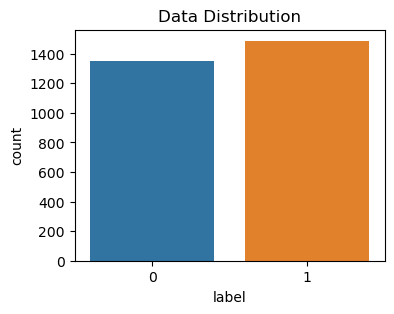

In [40]:
plt.figure(figsize=(4,3))
sns.countplot(x=new_df_stress['label'])
plt.title('Data Distribution')
plt.show()

Base on the bar plot above, this data is well balanced. So it can be useful for the training.

<h4>WordCloud

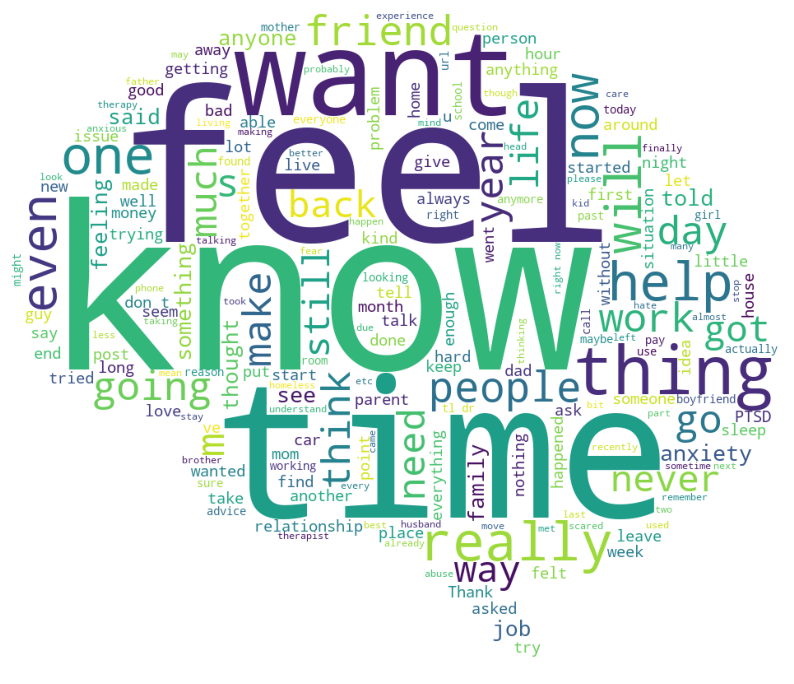

In [41]:
#Put all the text into one string
text = ''
for i in range(len(new_df_stress)):
    text = " ".join([text, new_df_stress['text'][i]]) 

#Generate a WordCloud with a brain mask
char_mask = np.array(Image.open('brain.png'))
wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS, 
                      colormap='viridis', mask=char_mask).generate(text)
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(wordcloud)

This WordCloud shows the most frequent words in the data. When people talk about stress, '**feel**', '**know**', '**time**', '**want**', '**help**' are the most common words. In addition, people may feel stressed about '**friend**', '**school**, '**work**', '**family**', and '**life**'.

<h4>Visualize Named Entities Using spaCy

In [42]:
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

colors = {'ORG': 'linear-gradient(to bottom right, #9E7BFF, #BDEDFF)', 
          'DATE': 'radial-gradient(#FFFFCC, #50C878)'}
options = {'ents': ['ORG', 'DATE'], 'colors':colors}

sample_text = nlp(new_df_stress['text'][10])
displacy.render(sample_text, style='ent', jupyter=True, options=options)

<h3>Developing a Model

<h4>Data Preparation for Training

In [45]:
#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(new_df_stress['text'], new_df_stress['label'],
                                                   test_size=0.25, random_state=1001)

I want to use the function I created earlier (*word_cleaner*) to preprocess this data. First, I need to make sure it also works with this new dataset.

In [46]:
#Try the function with the data
sample = random.randint(0, len(new_df_stress))
print('Original sentence:\n', new_df_stress['text'][sample],'\n')
print('After word_cleaner function:\n', word_cleaner(new_df_stress['text'][sample]))

Original sentence:
 The next day I called M and told him what happened. He was furious and talked about breaking up and told me I lied to him and he had trust issues because of his ex girlfriend who attacked him with a knife or hatchet or something. And it was one thing after another like that. Often about things that I didn't think were 'lying'. The next thing I knew I wasn't going out anymore because he'd always get mad for some reason. 

After word_cleaner function:
 ['next', 'day', 'call', 'told', 'happen', 'furiou', 'talk', 'break', 'told', 'lie', 'trust', 'issu', 'ex', 'girlfriend', 'attack', 'knife', 'hatchet', 'someth', 'one', 'thing', 'anoth', 'like', 'often', 'thing', 'didnt', 'think', 'lie', 'next', 'thing', 'knew', 'wasnt', 'go', 'anymor', 'hed', 'alway', 'get', 'mad', 'reason']


The function seems to work fine with this dataset. I can use the function directly.

<h4>Create a Pipeline using Naive Bayes Classifier

In [47]:
#Create a pipeline for our training data.
Pipe2 = Pipeline([
    ('cv', CountVectorizer(analyzer=word_cleaner)), #step 1 - Learn a vocabulary dictionary of all tokens
    ('tfid',TfidfTransformer()), # step 2 - Apply TFIDF
    ('clf',MultinomialNB()) # Step 3 - Train and Classify
])

In [48]:
#Fit the pipeline with the data.
Pipe2.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(analyzer=<function word_cleaner at 0x000001E3D600BDC0>)),
                ('tfid', TfidfTransformer()), ('clf', MultinomialNB())])

<h4>Create a Pipeline using Logistic Regression Classifier

In [51]:
#Create a pipeline for our training data.
Pipe3 = Pipeline([
    ('cv', CountVectorizer(analyzer=word_cleaner)), #step 1 - Learn a vocabulary dictionary of all tokens
    ('tfid',TfidfTransformer()), # step 2 - Apply TFIDF
    ('clf',LogisticRegression()) # Step 3 - Train and Classify
])

In [52]:
#Fit the pipeline with the data.
Pipe3.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(analyzer=<function word_cleaner at 0x000001E3D600BDC0>)),
                ('tfid', TfidfTransformer()), ('clf', LogisticRegression())])

<h4>Compare model accuracy

In [64]:
predicted_value2 = Pipe2.predict(X_test)
accuracy2 = round((accuracy_score(y_test, predicted_value2) * 100),2)
print("The accuracy of Naive Bayes classifier is {}%".format(accuracy2))

predicted_value3 = Pipe3.predict(X_test)
accuracy3 = round((accuracy_score(y_test, predicted_value3) * 100),2)
print("The accuracy of Logistic Regression classifier is {}%".format(accuracy3))

The accuracy of Naive Bayes classifier is 65.92%
The accuracy of Logistic Regression classifier is 74.79%


Apparently logistic regression is better with higher accuracy of 74.79%.

<h4>Compare model confusion matrix

In [56]:
#Create confusion matrices
from sklearn.metrics import confusion_matrix, classification_report
cf_mtx2 = confusion_matrix(y_test, predicted_value2)
cf_mtx3 = confusion_matrix(y_test, predicted_value3)

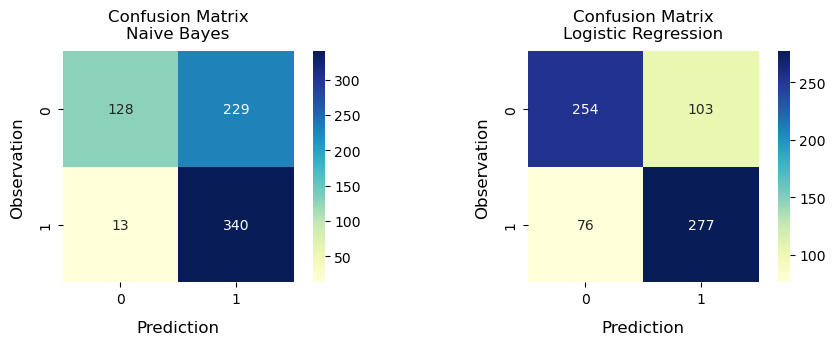

In [57]:
fig, axes = plt.subplots(ncols=2, figsize=(11,3))


sns.heatmap(ax=axes[0], data=cf_mtx2, annot=True, square=True, fmt='', cmap='YlGnBu')
sns.heatmap(ax=axes[1], data=cf_mtx3, annot=True, square=True, fmt='', cmap='YlGnBu')

axes[0].set_title('Confusion Matrix\nNaive Bayes', fontsize=12, y=1.02)
axes[1].set_title('Confusion Matrix\nLogistic Regression', fontsize=12, y=1.02)

for i in range(2):
    axes[i].set_ylabel('Observation', fontsize=12, labelpad=10)
    axes[i].set_xlabel('Prediction', fontsize=12, labelpad=10)

plt.show()

- Based on the plots above, we can see that there are less *false negatives* and more *true positives* in the Naive Bayes model. 
- However, the *false positives* are more than twice that of Logistic Regression model. 
- In addition, the *true negatives* of Naive Bayes model are only half that of Logistic Regression model. 

<h4>Compare Model Classification Report

In [58]:
print('--------Classification Report for Naive Bayes--------\n')
print(classification_report(y_test, predicted_value2))

--------Classification Report for Naive Bayes--------

              precision    recall  f1-score   support

           0       0.91      0.36      0.51       357
           1       0.60      0.96      0.74       353

    accuracy                           0.66       710
   macro avg       0.75      0.66      0.63       710
weighted avg       0.75      0.66      0.63       710



In [59]:
print('----Classification Report for Logistic Regression----\n')
print(classification_report(y_test, predicted_value3))

----Classification Report for Logistic Regression----

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       357
           1       0.73      0.78      0.76       353

    accuracy                           0.75       710
   macro avg       0.75      0.75      0.75       710
weighted avg       0.75      0.75      0.75       710



- The classification reports also proved that Logistic Regression model has a lower precision score for label 0 and lower recall score for label 1. However, the overall accuracy, recall, and f1 score are well balanced for both labels.
- I will use Logistic Regression model to predict human stress.

<h2>V: Build a Chatbot Combining Conversational Module and Stress Prediction Module

<h3>Build the Chatbot

In [60]:
def chatbot():
    usr = input('Please enter your name: ')
    print('Pandora: Hello', usr+', welcome. You can chat with me about mental health or say goodbye if you want to quit.')
    text = ''
    while True:
        im = input('{}:'.format(usr))
        text = " ".join([text, im]) #Collect all the input data for stress prediction
        tag = Pipe.predict([im])[0] #Find the correct tag of the input
        response = df_faq.loc[df_faq['tag']==tag]['responses'].tolist()[0] #Find the corresponding responses
        rand_idx = random.randrange(len(response)) #Generate a random response from the responses
        
        if tag == 'goodbye':
            stress_score = Pipe3.predict([text]) #Predict the stress score
            if stress_score == 1:
                print('Pandora: Based on our conversation, there is a high probability that you are having psychological stress.') 
                print('Pandora: Here is a link that may be helpful: https://www.healthline.com/health/psychological-stress')
                print('Pandora: A therapist or mental health professional can also help you find ways to manage your stress.')
                print('Pandora: '+response[rand_idx])
            else:
                print('Pandora: '+response[rand_idx])
            break
        else:  
            print('Pandora: '+response[rand_idx])    

<h3>Test the Chatbot

<h4>Situation: Stress

In [61]:
chatbot()

Please enter your name: Lilac
Pandora: Hello Lilac, welcome. You can chat with me about mental health or say goodbye if you want to quit.
Lilac:I cannot sleep
Pandora: That seem awful. What do you think is behind this?
Lilac:I am stressful
Pandora: Give yourself a break. Go easy on yourself.
Lilac:I want some advice
Pandora: Okay what do you need advice on?
Lilac:What is mental health
Pandora: Mental health is a state of well-being in which the individual realizes his or her own abilities, can cope with the normal stresses of life, can work productively and fruitfully, and is able to make a contribution to his or her community
Lilac:Am I depressed?
Pandora: Talk to me. Tell me more. It helps if you open up yourself to someone else.
Lilac:Thank you
Pandora: Happy to help!
Lilac:Bye!
Pandora: Based on our conversation, there is a high probability that you are having psychological stress.
Pandora: Here is a link that may be helpful: https://www.healthline.com/health/psychological-stress
P

<h4>Situation: No Stress

In [62]:
chatbot()

Please enter your name: Lilac
Pandora: Hello Lilac, welcome. You can chat with me about mental health or say goodbye if you want to quit.
Lilac:Good morning
Pandora: Good morning. I hope you had a good night's sleep. How are you feeling today? 
Lilac:I feel great
Pandora: What do you think is causing this?
Lilac:I am happy
Pandora: Did something happen which made you feel this way?
Lilac:Tell me a joke
Pandora: mental health is not a joke.
Lilac:You are right
Pandora: I'm Pandora!
Lilac:Goodbye
Pandora: Bye! Come back again.


<h4>An Ester Egg

I added a response to the original dataset. If you ask "Who created you?", you may see the ester egg. 

In [63]:
chatbot()

Please enter your name: Lilac
Pandora: Hello Lilac, welcome. You can chat with me about mental health or say goodbye if you want to quit.
Lilac:Who created you?
Pandora: The real question is: Who created you?
Lilac:Who created you?
Pandora: I was trained on a text dataset using Deep Learning & Natural Language Processing techniques
Lilac:Who created you?
Pandora: I was created by a student named Chao for her midterm project.
Lilac:ok bye
Pandora: Have a nice day.


<h2>VI: Conclusion 

For this project, I created a chatbot who can make general conversations and anwer questions related to mental health. Before the user leave the conversation, the chatbot will collect all the user inputs and predict if the user has psychological stress. The chatbot also will give user advice if stress is predited. 
- For both models, I used Count Vectorization and TF-IDF to transform the text.
- For converstaion model, I used Decision Tree as my classifier because it has better accuracy when classifing the question tags compared with other classifiers such as SVM and Naive Bayes. However, due to the lack of similar questions and sufficient data, this model cannot predict correctly if the questions are not similar to the training data.
- For stress prediction model, I used Logistic Regression as my classifier because it has better overall accuracy, recall, and f1 score compared with Naive Bayes. Although this model is well balanced for predicting both labels, the overall accuracy is only 74.79%, which is not ideal.
- I hope I will learn more techniques later in the course such as deep learning to see if the chatbot can perform better.
